In [1]:
# https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

# 그냥 돌리면 No module named 'sklearn.__check_build._check_build' 에러가뜸
# cmd를 켜서
# 돌리기전에 C:\Users\USER\Anaconda3\lib\site-packages\sklearn\__check_build 디렉토리로 가서
# python setup.py install`을 입력해야한다.
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# **Load and Check data**

## 2.1 Load data

In [2]:
train = pd.read_csv("./dataset/train.csv")
test=pd.read_csv("./dataset/test.csv")
IDtest=test["PassengerId"]

## 2.2 Outlier Detection

In [3]:
# Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices.
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices=[] #리턴하는대상인데, 얘가 리스트형태
    
    #iterate over features(columns): 반복한다 features(컬럼)
    for col in features:
        # quartile : 1/4
        #1 st quartile(25%)
        Q1= np.percentile(df[col], 25)
        
        #3rd quartile(75%)
        Q3= np.percentile(df[col], 75)
        
        #interquatile range (100%)
        IQR= Q3-Q1
        
        #outlier step
        outlier_step = 1.5 * IQR
        
        #determine a list of indices of outliers for feature col
        outlier_list_col = df[ (df[col] < Q1- outlier_step) | (df[col]> Q3+outlier_step ) ].index
        
        #append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    
    #select observations containing more than 2 outliers 2개의 outlier보다 큰 관측값만 선택
    outlier_indices= Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers


# 트레인데이터셋, 2, features를 입력으로 detect_outliers 함수 호출 
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

C:\Users\USER\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
## Drop Outliers
### We detect 10 outliers (10개의 outlier을 감지했다)
### passenger id 가 28, 89 ,342 인 승객은 19950 티켓 비싼 티켓을 가졌다.
### fare이 263.00으로 꽤 높다. 나머지승객들은 SibSp가 8로 매우 높은 값을 가졌다.
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 Joining train and test set

In [6]:
# Join train and test dataset inorder 
# to obtain the same number of features during categorical conversion
# 테스트와 트레인 데이터셋은 결합한다.
# 카테고리화하는 전환(카테고리화)하는 동안 같은 숫자의 feature을 얻기위해서...

train_len = len(train) #트레인 데이터셋의 길이를 구한다.
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


## 2.4 Check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN : 비어있거나 NaN 값을 채운다...
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum

# 생존자의 값이 없는 곳은 테스트데이터셋과 조인을 할 필요가 잇다.
# survived 컬럼은 존재하지 않는다 테스트셋에서 
# 그리고 train과 test를 연결시킬 때  NaN값으로 대체된다. 

<bound method DataFrame.sum of         Age  Cabin  Embarked   Fare   Name  Parch  PassengerId  Pclass    Sex  \
0     False   True     False  False  False  False        False   False  False   
1     False  False     False  False  False  False        False   False  False   
2     False   True     False  False  False  False        False   False  False   
3     False  False     False  False  False  False        False   False  False   
4     False   True     False  False  False  False        False   False  False   
5      True   True     False  False  False  False        False   False  False   
6     False  False     False  False  False  False        False   False  False   
7     False   True     False  False  False  False        False   False  False   
8     False   True     False  False  False  False        False   False  False   
9     False   True     False  False  False  False        False   False  False   
10    False  False     False  False  False  False        False   False  False 

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# summarize data : 데이터 요약
# summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature Analysis

## 3.1 Numerical values (숫자값)

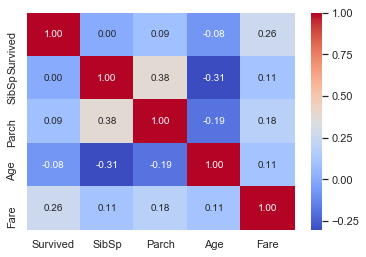

In [12]:
# correlation matrix between numerical values ( SibSp Parch Age Fare values) and survived
# 숫자값으로 된 것들 관계행렬이다.
g= sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

 Only Fare feature seems to have a significative correlation with the survival probability
 Fare 컬럼은 생존 가능성과 중요한 관계가 있어보인다.

 이것은 다른 feature은 쓸모없다는게 아니다. 
 이 특징들 중에서 Subpopulations(부분모집단)은 survival과 연관될 수 도 있다.
 이걸로 결정을하자면, 이 feature들(survived, sibsp, parch, age, fare)로 탐색해볼 필요가있다.

## SibSP

C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


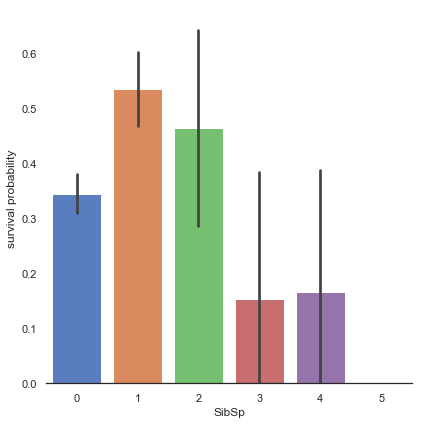

In [13]:
# Explore SibSP(타이타닉에 탄 형제자매, 배우자) vs Survived
# 컬럼 SipSP가 Survived(생존가능성)와 관련이 있을까?

g= sns.catplot( x="SibSp", y="Survived", data=train, kind="bar", height=6
                  , palette="muted")

g.despine(left=True)
g= g.set_ylabels("survival probability")

In [14]:
# SibSp 와 타이타닉 생존가능성 을 나타내는데..
# 이 그래프를 통해서 얻을 수 있는 insight는... 
# 형제/자매/배우자 가 없거나(0), 1~2 까지는 그래도 생존가능성이 높다.

## ParCh

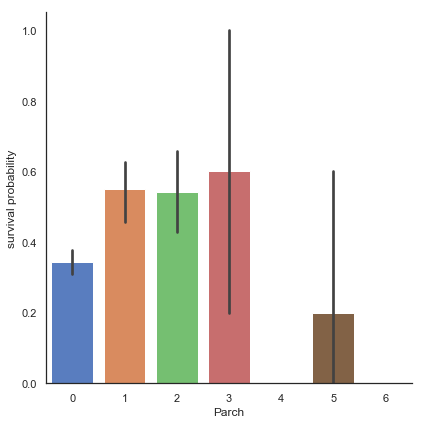

In [15]:
# despine을 사용하기 전

# 부모나 자식이 타이타닉에 탔을 때 생존가능성...
g = sns.catplot( x="Parch", y="Survived", data=train
               , kind="bar", height=6, palette="muted")

# seaborn.despine(): Remove the top and right spines from plots
# 맨 위와 오른쪽의 뼈대(spine)을 제거한다...
#g.despine(left=True)
g= g.set_ylabels("survival probability")

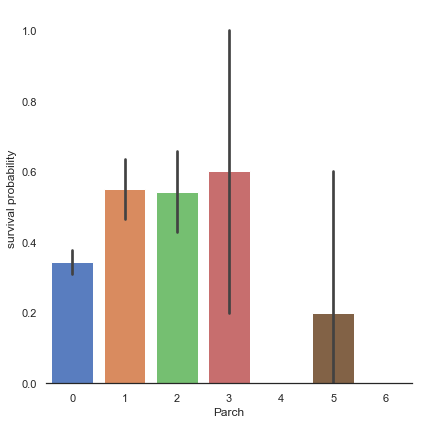

In [16]:
# despine을 사용한 후

# 부모나 자식이 타이타닉에 탔을 때 생존가능성...
g = sns.catplot( x="Parch", y="Survived", data=train
               , kind="bar", height=6, palette="muted")

# seaborn.despine(): Remove the top and right spines from plots
# 맨 위와 오른쪽의 뼈대(spine)을 제거한다...
g.despine(left=True) # 왼쪽 축(선)을 제거.
g= g.set_ylabels("survival probability")

In [17]:
# ParCh 와 생존가능성의 얻을수 있는 관계=> 가족, 자녀가 3명 이하는 가능성이 있다.
# !~3가량? 이정도가 0.5를 넘는다.
# 검은색 선은 신뢰도를 나타낸다.

## Age

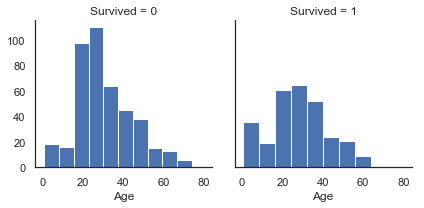

In [18]:
#타이타닉 생존가능성과 나이의 관계
g= sns.FacetGrid(train, col='Survived')
g=g.map(plt.hist, "Age")  # sns.displot을 제외
# 파란색막대 :트레인 데이터셋.

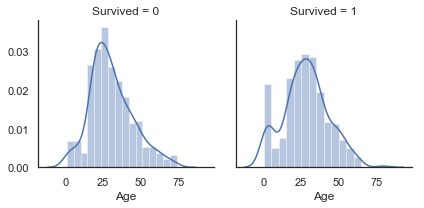

In [19]:
#타이타닉 생존가능성과 나이의 관계
g= sns.FacetGrid(train, col='Survived')
g= g.map(sns.distplot, "Age")

In [20]:
# 나이(Age) 분포는 tailed distribution 처럼 보인다. 가우시안 distribution
# age distribution은 survived와 같지 않다., 죽은사람들(not survived)와도 같지않다.

# 어린 승객들은 많이 살아남았다.60-80은 생존률이 거의 없고...
# age가 survived하고는 관련이 없다... 

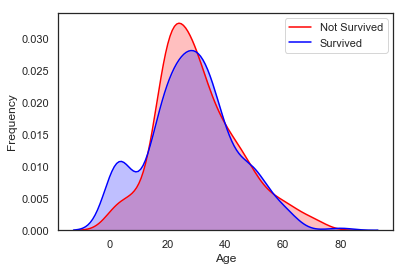

In [21]:
# Explore Age Distribution
# 생존 못함(Not Survived)
g= sns.kdeplot( train["Age"][(train["Survived"]==0) & (train["Age"].notnull())],
              color="Red", shade=True)

# 생존(Survived)
g= sns.kdeplot( train["Age"][(train["Survived"]==1) & (train["Age"].notnull())],
              color="Blue", shade=True)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g= g.legend(["Not Survived", "Survived"])

## Fare

In [22]:
dataset["Fare"].isnull().sum()

1

In [23]:
# Fill Fare missing value with the median value
# 값이 없는 것은 median중앙값으로 넣는다.
dataset["Fare"]= dataset["Fare"].fillna(dataset["Fare"].median())

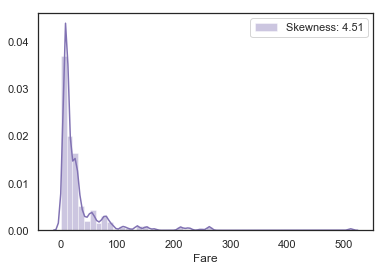

In [24]:
# Explore Fare Distribution
g= sns.distplot( dataset["Fare"], color="m", label="Skewness: %.2f"%(dataset["Fare"].skew()))
g=g.legend(loc="best")

In [25]:
# # distribution이 skewed(왜곡)되어있다.
# 이것은 매운큰값으로 overweight로 이끌수도있다. 비록 변경하더라도(scaled)
# 이러한 경우는 log function을 이용하여 skew(왜곡)을 줄이는게 좋다.

# Applying log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i>0 else 0)

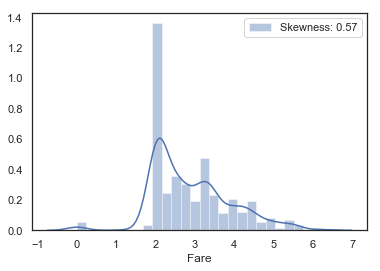

In [26]:
g= sns.distplot(dataset["Fare"], color="b"
                , label="Skewness: %.2f"%(dataset["Fare"].skew()))

g=g.legend(loc="best")
# skewness is clearly reduced after the log transformation....
# 로그 변환을 이용하여 왜곡됨이 깨끗하게 제거됐다.

## 3.2 Categorical Values

## Sex (성별)

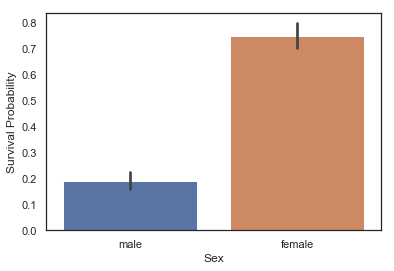

In [27]:
g= sns.barplot( x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [28]:
train[ ["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [29]:
# 남성이 여성보다 생존가능성이 낮았다.
# 성별도 생존가능성 예측에서 중요한 역할을 한다.
# Women and children first 라는 대사가 있는데 실제로 그러지 않았을까...

## Pclass(티켓 클래스)

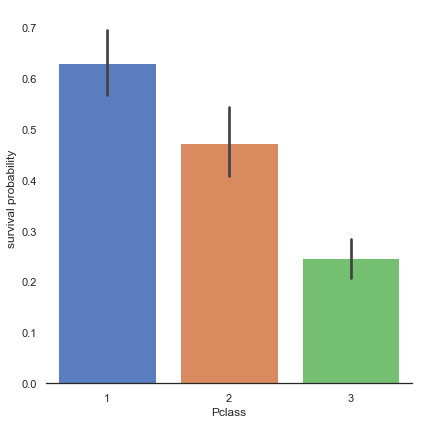

In [30]:
g= sns.catplot(x="Pclass", y="Survived", data=train
                  ,kind="bar", height=6, palette="muted")

g.despine(left=True) #y축 선 제거
g=g.set_ylabels("survival probability")

# Pclass가 낮은숫자일수록 생존률이 높다.

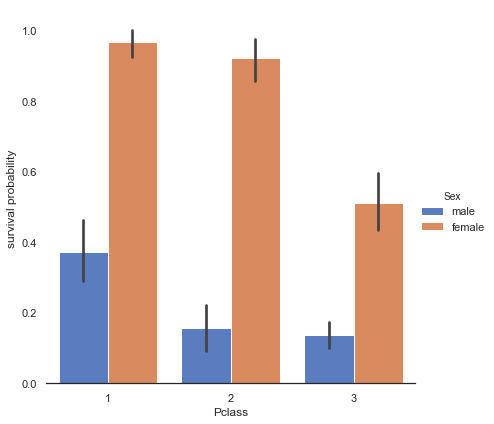

In [31]:
# Explore Pclass vs Survived by Sex (Pclass 에서도 남자여자로 또 분류 )
g= sns.catplot(x="Pclass", y="Survived", hue="Sex"
                 ,data=train, kind="bar", height=6, palette="muted" )

g.despine(left=True)
g= g.set_ylabels("survival probability")

#Pclass(티켓클래스) 상관없이 여성이 생존율이 높다...

In [32]:
# 3개의 클래스에서 생존률은 같지 않다.
# 첫번째 클래스 승객들은 다른 클래스의 승객보다 생존률이 높다.

## Embarked ( Port of Embarkation 출항지)

In [33]:
dataset["Embarked"].isnull().sum()

2

In [34]:
# Fill Embarked NaN values of dataset set with 'S' most frequent value
dataset["Embarked"]=dataset["Embarked"].fillna("S")

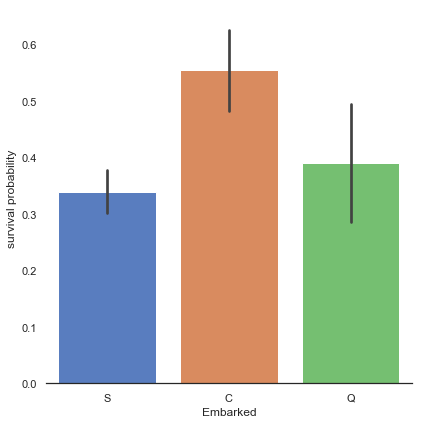

In [35]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived", data=train
                ,height=6, kind="bar", palette="muted")

g.despine(left=True)
g=g.set_ylabels("survival probability")

In [36]:
# 출항지가 C(Cherbourg)로부터 온 승객이 생존확률이 높다.
# 다음은 Pclass와 Embarked간의 관계이다.

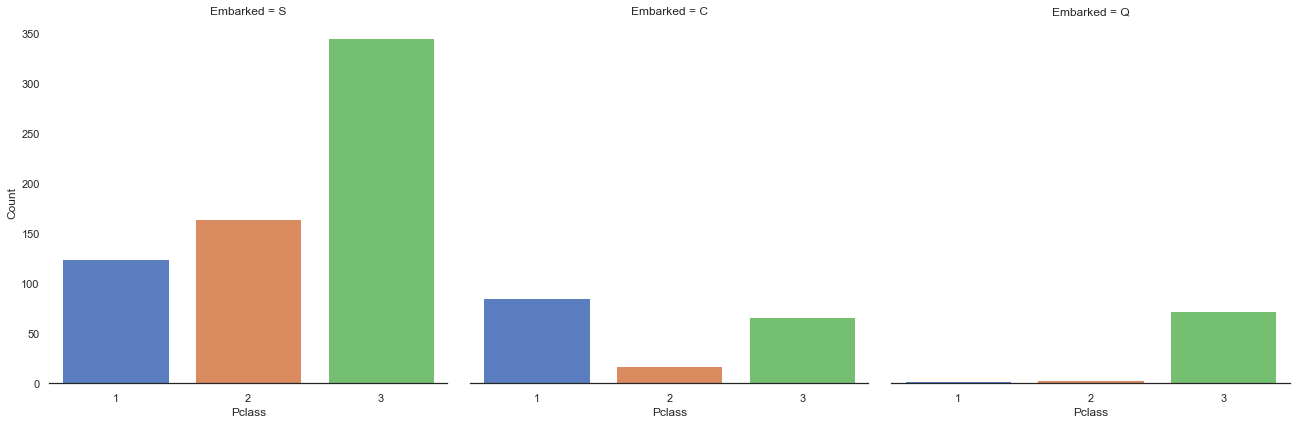

In [37]:
# Explore Pclass vs Embarked
# 그래프는 Embarked로 구분... 서브그래프의 막대는 Pclass로 구분
g= sns.catplot("Pclass", col="Embarked", data=train
              , height=6, kind="count", palette="muted")
g.despine(left=True)
g=g.set_ylabels("Count")

## Filling missing Values

## 4.1 Age

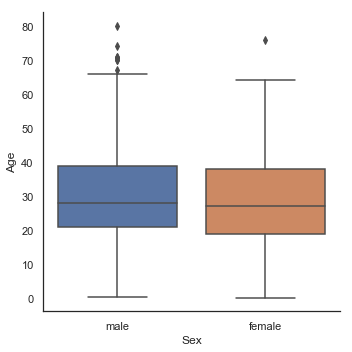

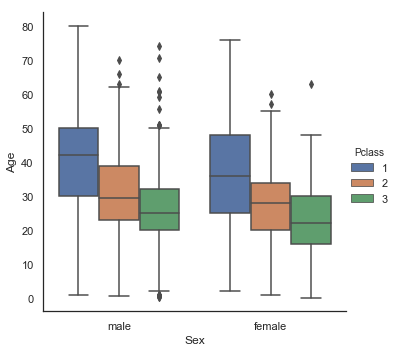

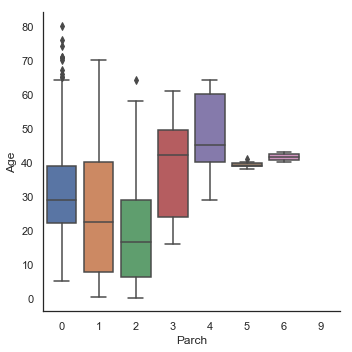

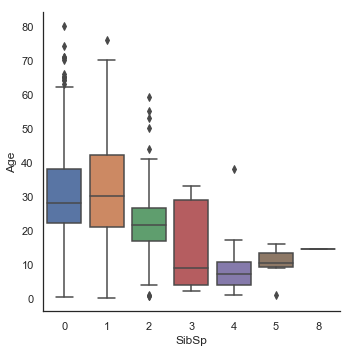

In [38]:
# Age Column 에서 전체 데이터셋 중 256개 데이터가 누락되었다.
# 생존할 수 있는 기회가 더 많은 하위집단(어린이)가 있기때문에
# 연령 특성을 유지하고 누락된 값 탓을 톨리는게 바람직하다...

# 그래서 age, sex, parch, pclass, sibsp 관련된 특성들을 살펴봤다.
# Explore Age vs Sex, Parch, Pclass , SibSp

g= sns.catplot(y="Age", x="Sex", data=dataset, kind="box")

g= sns.catplot(y="Age", x="Sex", hue="Pclass" ,data=dataset, kind="box")

g= sns.catplot(y="Age", x="Parch", data=dataset, kind="box")

g= sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

In [39]:
# Age distribution에서는 남성과 여성 부분모집단에서 .. 
# sex(성별)는 age를 예측하는데 정보를 제공해주지않는다.

#Pclass와 Age관계에서
# pclass=1이 다른클래스보다 나이가 더 많다.pclass=2가 3보다 더 나이가 많다.

In [40]:
# convert sex into categorical value 0 for male 1 for female
# sex(성별)을 0과 1로 나타냄 (남성: 0, 여성:1)
dataset["Sex"]=dataset["Sex"].map({"male":0, "female":1})

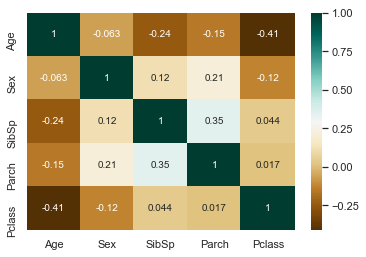

In [41]:
g = sns.heatmap( dataset[ ["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr()
                ,cmap="BrBG", annot=True)

In [42]:
# Age는 Sex와 관련없다...
# Age는 Pclass, SibSp, Parch 와 음수로 관련있다.
# Parch와 Age는 parent/children 수가 높을 수록 높아지고...
# 그러나 일반적인 관계는 음수이다.

# SibSp, Parch, Pclass를 사용 ... age값이 없는 것을 impute하기위해서..
# age를 채우는 전략은 median age pclass, parch, sibsp에 따라 유사한 로우로..

In [43]:
# Filling missing value of age
# fill age with the median age of similar rows according to Pclass, Parch, sibsp

#index of NaN age rows
index_NaN_age= list( dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred= dataset["Age"][ ((dataset['SibSp']==dataset.iloc[i]["SibSp"]) & (dataset['Parch']==dataset.iloc[i]["Parch"]) & (dataset['Pclass']==dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i]=age_pred
    else:
        dataset['Age'].iloc[i]=age_med
    

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


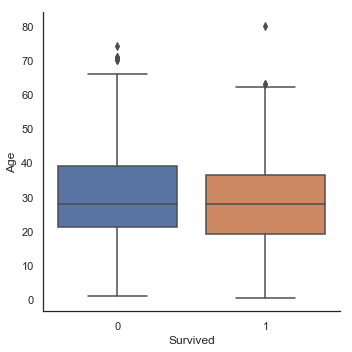

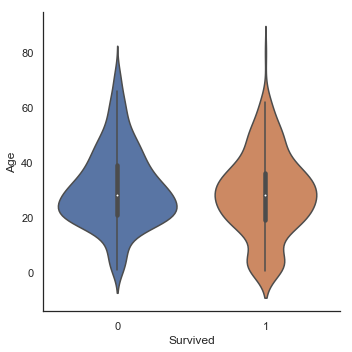

In [44]:
g=sns.catplot(x="Survived", y="Age", data=train, kind="box")
g=sns.catplot(x="Survived", y="Age", data=train, kind="violin")

In [45]:
#  생존자 age의 중앙값과 사망자 age의 중앙값간의 차이는 없다.
# violin 그래프에서는 젊은 층이 많이 살아남았다.(20대미만...)

# 5. Feature Engineering

## 5.1 Name/Title

In [46]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [47]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"]= pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

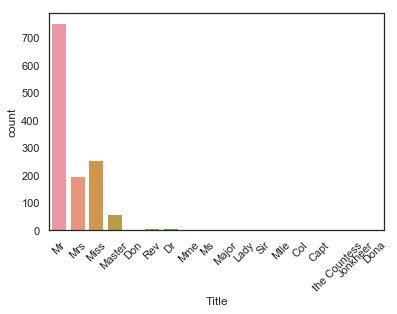

In [48]:
# https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
# In[36] 까지 했음

g= sns.countplot(x="Title", data=dataset)
g= plt.setp(g.get_xticklabels(), rotation=45)

In [49]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

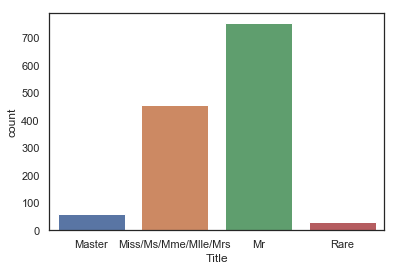

In [50]:
g= sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

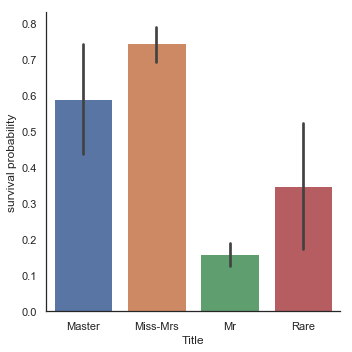

In [51]:
g= sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g= g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g= g.set_ylabels("survival probability")

In [52]:
# Rare 인 승객들이 더 살아남을 가능성이 있다.

In [53]:
# Drop Name Variable
dataset.drop(labels=["Name"], axis=1, inplace=True)

## 5.2 Family Size

In [54]:
# 큰 가족단위일수록 evacuate(대피시키다) 대피시키는데 어려울 수도있다고 생각한다.
# 자매, 형재, 부모 를 대피시키는 동안에... Fsize(family size)를 만들었고 이것은 SibSp와 Parch그리고 승객한명을 합친 결과이다.

# Fsize: parch + sibsp
# create a family size descriptor from sibsp and parch
dataset["Fsize"]= dataset["SibSp"]+dataset["Parch"]+1

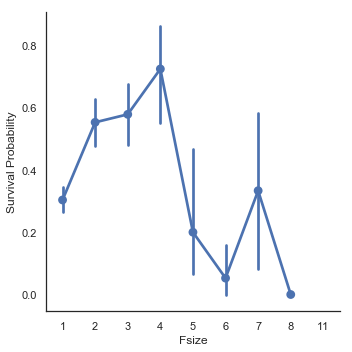

In [55]:
#g= sns.factorplot(x="Fsize", y="Survived", data=dataset) #rename됨...
g= sns.catplot(x="Fsize", y="Survived", data=dataset, kind="point")
g= g.set_ylabels("Survival Probability")

In [56]:
# family size는 survival probability에 중요한 역할을 한다.
# 가족단위가 클수록 생존가능성은 최악이다.
# 저자는 가족사이즈를 4개로 카테고리화 시켰다.

# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)#싱글

dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)#본인포함 가족 2명

dataset['MedF']= dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)#본인포함 가족 3~4명

dataset['LargeF']= dataset['Fsize'].map(lambda s:1 if s>4 else 0)#본인포함 가족5명이상


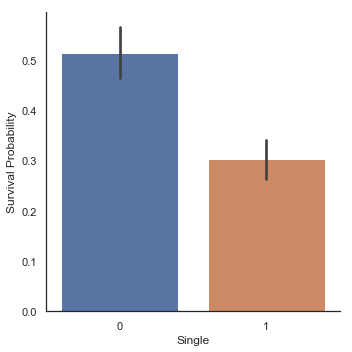

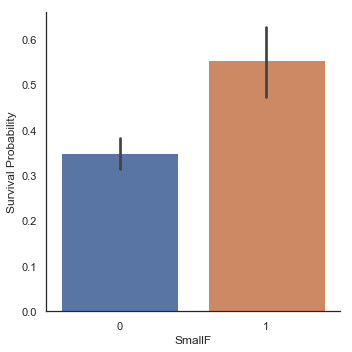

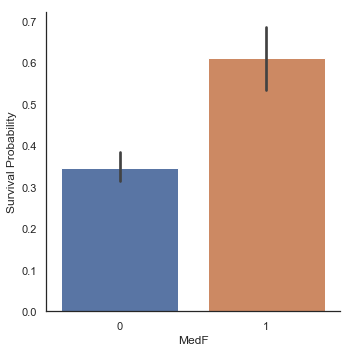

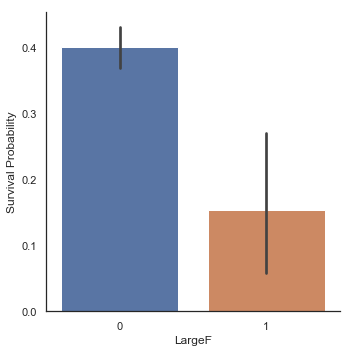

In [57]:
# 가족단위 카테고리별로 생존율를 나타냄
g= sns.catplot(x="Single", y="Survived", data=dataset, kind="bar")
g= g.set_ylabels("Survival Probability")

g= sns.catplot(x= "SmallF", y="Survived", data=dataset, kind="bar")
g= g.set_ylabels("Survival Probability")

g= sns.catplot(x= "MedF", y="Survived", data=dataset, kind="bar")
g= g.set_ylabels("Survival Probability")

g= sns.catplot(x= "LargeF", y="Survived", data=dataset, kind="bar")
g= g.set_ylabels("Survival Probability")


In [58]:
# 가족 사이즈의 카테고리별로 나타낸 catplot(막대그래프)는 small, medium 가족들이 더 생존가능성이있다 싱글이나 large사이즈가족보다...

# Embark : 출발지 포트..?
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix="Em")

In [59]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [60]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [61]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [62]:
dataset["Cabin"].isnull().sum()

1007

In [63]:
# Cabin feature 컬럼은 292개의 값을 가지고있고 1007개의 값없는 데이터가 있다..
# cabin없는 승객은 cabin 넘버대신에 나타낸 missing(빈값) 값을 가지고 있다고 강조한다..

# notnull인것만 ..
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [64]:
# Replace the Cabin number by the type of cabin 'X' if not
# cabin 넘버가 존재하지 않으면 X를 캐빈넘버로 한다.
dataset["Cabin"]= pd.Series([ i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

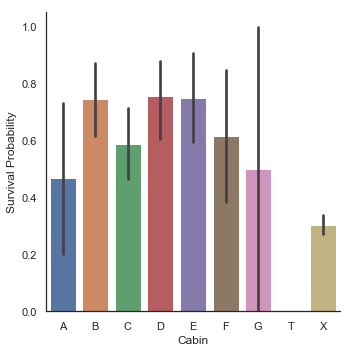

In [65]:
g= sns.catplot(y="Survived", x="Cabin", data=dataset, order=['A','B','C','D','E','F','G','T','X'], kind='bar')
g= g.set_ylabels("Survival Probability")

In [66]:
# cabin에서 승객수가 적은것 때문에.. 
# 생존가능성은 중요한 표준의 탈선을 갖고 있고 
# 우리는 생존가능성과 승객마다 항구 사이의 관계를 구분할 수 없다...

# 우리는 cabin번호를 갖는 승객이 더 살아남는 가능성이있다 캐빈넘버가 X인 승객보다(캐빈넘버가 없어서 X로 함..)
# 캐빈넘버가 B,C,D,E,F 가 생존가능성이 높은편...
dataset = pd.get_dummies( dataset, columns=["Cabin"], prefix="Cabin")


## 5.4 Ticket

In [67]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

똑같은 prefix를 공유하는 티켓들은 함께 cabin에 예약되어있다..
이것은 ship과 cabin의 실제 위치를 이끈다.
똑같은 prefix갖는 티켓들은 등급과 생존이 유사할 수 있다...? 
그래서 나는 티켓특징을 컬럼을 티켓 prefix로 대체했다. 티켓 prefix가 더 정보를 잘 준다..

In [68]:
# Treat Ticket by extracting the ticket prefix.
# When there is no prefix it returns X
# 티켓 prefix로 축약시켜서 티켓을 다룬다.. 티켓의 prefix가 없다면 X로 한다.

Ticket=[]
for i in list(dataset.Ticket):
    if not i.isdigit():
        # prefix를 얻는다.
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0] )
        
    else:#prefix가 없다면..
        Ticket.append("X")

dataset["Ticket"]=Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [69]:
dataset=pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [70]:
# Create categorical values for Pclass
# pclass에 대한 카테고리화된 값을 만든다..pclass별로 분류..
dataset["Pclass"]= dataset["Pclass"].astype("category")
dataset= pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [71]:
# Drop useless variables :쓸떼없는 variables는 지운다.
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [72]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. Modeling

In [73]:
## Seperate train dataset and test dataset
# 트레인 데이터셋과 테스트 데이터셋을 구분한다.
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [74]:
## seperate train features and label (트레인 특징과 라벨을 구분)
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop( labels=["Survived"], axis=1)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 6.1 Simple Modeling
### 6.1.1 Cross Validate models 
10개의 유명한 분류모델들과 각모델들의 정확도의 평균값으로 분류모델들을 가지고 비교..
stratified kfold cross validation 과정으로 분류모델을 평가..

In [75]:
# cross validate model with kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

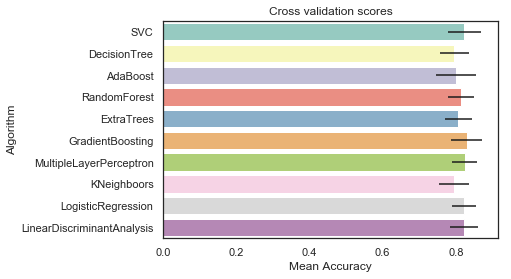

In [76]:
# modeling step test differents algorithms..
random_state =2
classifiers= []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state= random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append( cross_val_score(classifier, X_train, y=Y_train,
                                       scoring="accuracy", cv=kfold, n_jobs=4 ))    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res=pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g=sns.barplot("CrossValMeans", "Algorithm", data=cv_res, 
              palette="Set3", orient="h", **{'xerr':cv_std})

g.set_xlabel("Mean Accuracy")
g=g.set_title("Cross validation scores")

나는 결정했다 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류모델을 앙상블하기 위해서 선택했다.

## 6.1.2. Hypterparameter tunning for best models.

AdaBoost , Extra Tree, RandomForest, GradientBoosting SVC 분류모델을 선호한다.

나는 n_jobs 라는 파라미터를 4개.. 4개의 cpu를 갖는다.
그래서 계산하는데 걸리는 시간이 명확하게 줄어들었다.
조심해라 이과정은 매우 길게 걸린다 4개의 cpu만으로도 15분이 걸렸다.

In [77]:
## META MODELING WITH ADABOOST , RF, EXTRATREES, GRADIENT BOOSTRING

# Ada boost
DTC= DecisionTreeClassifier()

adaDTC= AdaBoostClassifier(DTC, random_state=7)

ada_param_grid={"base_estimator__criterion":["gini", "entropy"],
                "base_estimator__splitter":["best", "random"],
                "algorithm":["SAMME", "SAMME.R"],
                "n_estimators":[1,2],
                "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3 , 1.5]
               }

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid,cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)
ada_best= gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 920 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   29.1s finished


In [78]:
gsadaDTC.best_score_

0.8240635641316686

In [79]:
# ExtraTrees
ExtC= ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = { "max_depth": [None],
                "max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap": [False],
                "n_estimators": [100, 300],
                "criterion": ["gini"]}

gsExtC= GridSearchCV( ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best= gsExtC.best_estimator_

#ExtraTree Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.8min finished


0.8308740068104427

In [80]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

#Search grid for optimal parameters
rf_param_grid={"max_depth": [None],
              "max_features": [1,3,10],
              "min_samples_split":[2,3,10],
              "min_samples_leaf":[1,3,10],
              "bootstrap":[False],
              "n_estimators":[100,300],
              "criterion":["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best=gsRFC.best_estimator_

#Best Score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  3.0min finished


0.8320090805902384

In [81]:
# Gradient boosting tunning

GBC= GradientBoostingClassifier()
gb_param_grid= {'loss': ["deviance"],
               'n_estimators': [100, 200, 300],
               'learning_rate':[0.1, 0.05, 0.01],
               'max_depth':[4,8],
               'min_samples_leaf': [100, 150],
               'max_features':[0.3, 0.1]
               }

gsGBC= GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best= gsGBC.best_estimator_

# Best Score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.5min finished


0.8331441543700341

In [82]:
## SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best= gsSVMC.best_estimator_

#Best Score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.6min finished


0.8331441543700341

## 6.1.3 Plot learning curves

Learning curves는 오버피팅 효과를 보기위한 좋은 방법이다.
오버피팅 효과는 트레이닝셋과 트레이닝 사이즈는 정확도에 영향을 준다..

In [83]:
def plot_learning_curve( estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    # 간단한 테스트와 트레이닝 학습 커브 그래프를 만든다
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X,y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean= np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean= np.mean(test_scores, axis=1)
    test_scores_std= np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

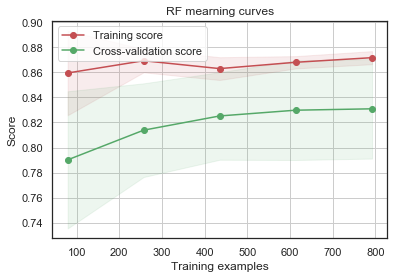

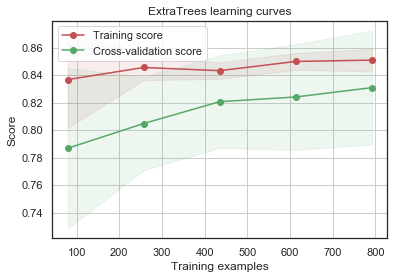

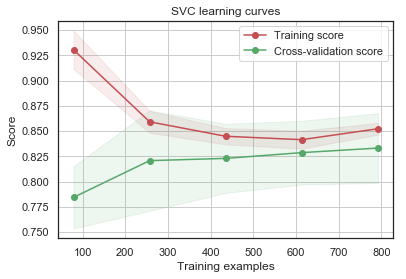

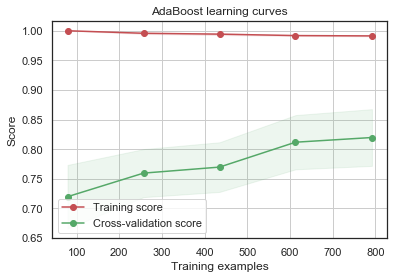

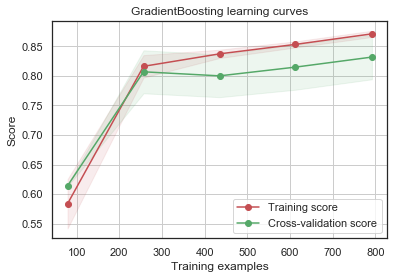

In [84]:
g= plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)

g= plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)

g= plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)

g= plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)

g= plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

 gradient boosting 과 Adaboost 분류모델은 트레이닝 데이터셋을 오버피팅하는 경향이 있다.

점점 증가하는 cross-validation 커브에 따르면, GradientBoosting과 Adaboost는 트레이닝 예제에 더 적합하다..

SVC, ExtraTrees 분류모델은 예측을 일반화를 잘한다. 

트레이닝테이터셋이 과 cross-validation 커브가 거의 밀접하게 있기때문이다.

### 6.1.4 Feature importance of tree based classifiers

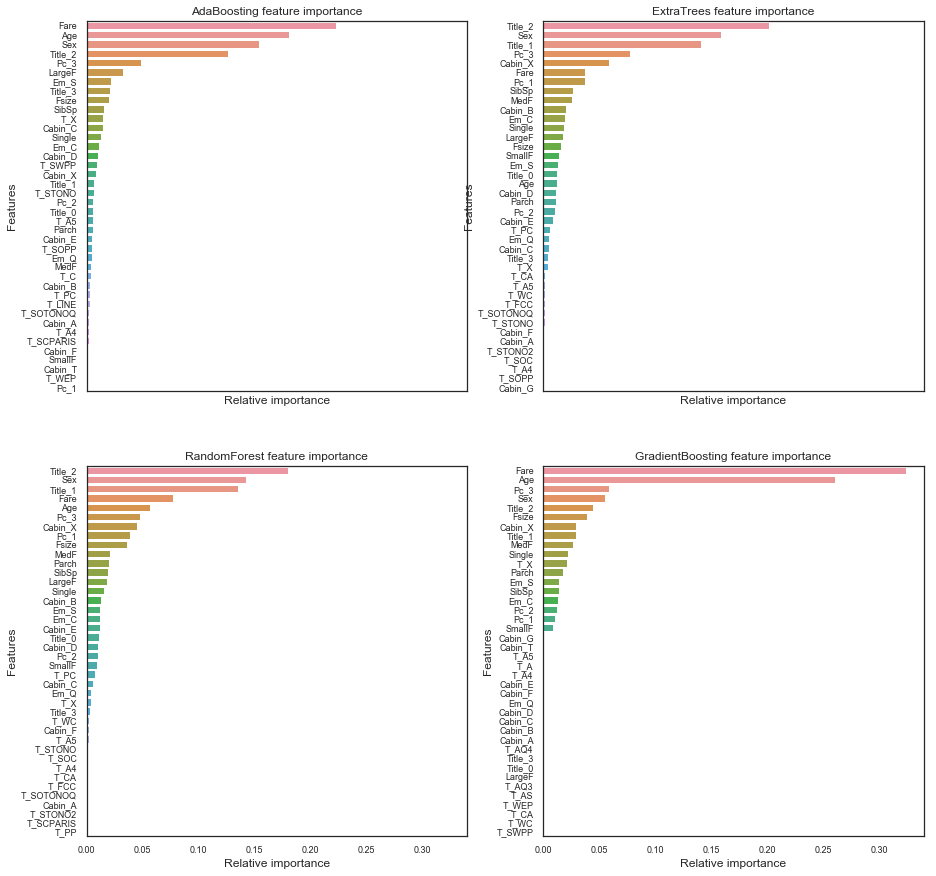

In [85]:
## 6.1.4 Feature importance of tree based classifiers

# 승객의 생존가능성 예측에서 가장 유용한 특징을 보기위해서  
#나는  트리를 기반으로 하는 분류모델 4개로 feature특징의 중요도를 시각화했다. 

nrows= ncols=2
fig, axes=plt.subplots( nrows=nrows, ncols=ncols, sharex="all", figsize=(15,15))

names_classifiers=[("AdaBoosting", ada_best), ("ExtraTrees", ExtC_best),
                 ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier=0
for row in range(nrows):
    for col in range(ncols):
        name=names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g=sns.barplot(y=X_train.columns[indices][:40], 
                      x=classifier.feature_importances_[indices][:40],
                     orient='h', ax=axes[row][col])
        
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier+=1

In [86]:
"""
나는  4개의 트리기반 모델 분류에 대한 특징 중요도를 시각화했다.
(AdaBoost, ExtraTrees, RandomForest, GradientBoosting)

4개의 모델분류가 관련있는 중요도에 따라 중요하게 여기는 특징을 다르게 나타냄을  보여준다.
이건 각각의 모델들은 똑같은 특징을 기반으로 예측하지 않음을 의미한다.

그럼에도 불구하고 분류에 있어서 4개모두 공통의 중요 특징을 공유한다.
예를 들면 Fare, Title_2, Age, Sex 컬럼이다..

Title_2 는 Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타낸다.
이러한 명칭들은 Sex(성별)과 관련잇다.

Pc_1, Pc_2, Pc_3, Fare은 승객의 사회적지위를 나타낸다.

Sex(성별)과  Title_2(Mrs/Mlle/Mme/Miss/Ms)과 Title_3(Mr) 성별을 나타낸다.

Age와 Title_1(Master)은 승객의 나이를 나타낸다.

Fsize, LargeF, MedF, Single은 승객 가족의 규모를 나타낸다.

이러한 4개의 분류의 특징 중요성을 따르면, 
생존가능성 예측은 Age, Sex, Family 사이즈, 그리고 승객의 사회적 지위 가

boat에서의 위치보다 더 연관있다.

"""

'\n나는  4개의 트리기반 모델 분류에 대한 특징 중요도를 시각화했다.\n(AdaBoost, ExtraTrees, RandomForest, GradientBoosting)\n\n4개의 모델분류가 관련있는 중요도에 따라 중요하게 여기는 특징을 다르게 나타냄을  보여준다.\n이건 각각의 모델들은 똑같은 특징을 기반으로 예측하지 않음을 의미한다.\n\n그럼에도 불구하고 분류에 있어서 4개모두 공통의 중요 특징을 공유한다.\n예를 들면 Fare, Title_2, Age, Sex 컬럼이다..\n\nTitle_2 는 Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타낸다.\n이러한 명칭들은 Sex(성별)과 관련잇다.\n\nPc_1, Pc_2, Pc_3, Fare은 승객의 사회적지위를 나타낸다.\n\nSex(성별)과  Title_2(Mrs/Mlle/Mme/Miss/Ms)과 Title_3(Mr) 성별을 나타낸다.\n\nAge와 Title_1(Master)은 승객의 나이를 나타낸다.\n\nFsize, LargeF, MedF, Single은 승객 가족의 규모를 나타낸다.\n\n이러한 4개의 분류의 특징 중요성을 따르면, \n생존가능성 예측은 Age, Sex, Family 사이즈, 그리고 승객의 사회적 지위 가\n\nboat에서의 위치보다 더 연관있다.\n\n'

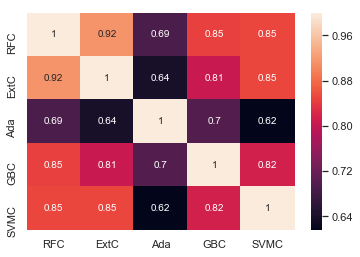

In [87]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC= pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC= pd.Series(SVMC_best.predict(test), name="SVMC")
test_Survived_AdaC= pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC= pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results 분류 결과를 연결..
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)
g= sns.heatmap(ensemble_results.corr(), annot=True)

In [ ]:
'''
이 예측은 5개의 모델이 유사해보이지만 
Adaboost 는 다른 분류와 비교할때만 예외가 있다..

5개의 분류는 동일한 예측을 갖는다.. 여기서 차이가 존재하는데
5개 분류모델에 대한 예측의 차이점은 앙상블 투표(?)를 비교하는데 충분하다..
'''

# 6.2 Esemble modeling (모델링 앙상블)

### 6.2.1 Combining models (모델 결합)

나는 선택했다 투표하는 모델들을 .. 5개 분류로부터 얻게되는 예측을 결합하기위해서

나는 soft한 인자가 voting 파라미터에 pass되기를 선호한다. 
각 vote의 가능성을 셀 수 있도록하는..

In [88]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('SVC', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

# 6.3 Prediction(예측)

## 6.3.1 Predict and submit results

In [89]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results=pd.concat([IDtest, test_Survived],axis=1)
results.to_csv("ensemble_python_voting.csv", index=False)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
